In [1]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics


def Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W):
    
    
    Area=pi*spotsize**2

    selector1 = sqrt(xoffset**2+yoffset**2) < spotsize
    selector2 = sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize


    print ( f'IP-laser spot size: {spotsize:.2f} micron')
    print ( f'baseline          : {baseline/1e6:.2f} metres')
    print ('-'*42)

    print (f'photons in spot')
    print (f'macrophoton weight               : {amax(W):.4g}')
    print ( 'macrophotons, zero   source size :',sum( selector1 ) )
    print ( 'macrophotons, finite source size :',sum( selector2 ) )
    print ( 'photon weight, zero   source size:',sum(W[selector1 ] ) )
    print ( 'photon weight, finite source size:',sum(W[selector2 ] ) )
    
    P1=sum(W[selector1 ] )/Area
    P2=sum(W[selector2 ] )/Area
    print ( f'Photon density, zero   source size:',P1)
    print ( f'Photon density, finite source size:',P2)
    
    print (' ######################################### '  )
    print ('                           '  )
    plt.figure(figsize=(14,6))

    ax1=plt.subplot(121,aspect=1)
    plt.scatter(xoffset, yoffset, color='r',marker='.',lw=0,s=W )
    plt.xlim(-2*spotsize,2*spotsize)
    plt.ylim(-2*spotsize,2*spotsize)
   
    plt.xlabel(r'$x$ (micron)')
    plt.ylabel(r'$y$ (micron)');
    plt.title(f'zero source size, Photon density:{round(P1,2)} micron^(-2)')


    ax2=plt.subplot(122,aspect=1)

    # plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);





    plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

    plt.xlim(-2*spotsize,2*spotsize)
    plt.ylim(-2*spotsize,2*spotsize)
    
    plt.xlabel(r'$x$ (micron)')
    plt.ylabel(r'$y$ (micron)');
    plt.title(f'Finite source size, Photon density:{round(P2,2)} micron^(-2)')

    ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))
    ax2.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


    plt.suptitle(f' sigmaT :{sigmaT} micron ; spotsize:{spotsize} micron')
    plt.savefig(f'photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)
    
    return(P1,P2)
                                      
    
                                   
def run(spotsize1,spotsize2,input_filename):
    

    
    
    with h5py.File(input_filename + '.h5' ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( input_filename + '.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        mode             = input_dict['control']['mode']


        beam_charge      = float( input_dict['beam']['beam_charge'])
        number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
        sampling = mode

        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
        gamma            = float(input_dict['beam']['gamma'])
        Xr               = 4*gamma*omega0/511*10**(-3)
        energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaT'])
#     print (f'beam charge                              : {beam_charge*1e12:.24} pC')
#     print (f'number of beam electrons                 : {number_electrons:.3e}')
#     print ('-'*42)
#     print (f'{sampling} sampling:')
#     print (f'max  single photon weight                : {amax(W):.4g}')
#     print (f'mean single photon weight                : {mean(W):.4g}')
#     print (f'total photon weight                      : {sum(W):.4g}')
#     print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
#     print (f'total macro photon number                : {len(W)}')
#     print ('-'*42)
#     print(f' Frequency (Laser) :  {omega0}'  )
#     print(f'Recoil Factor:{Xr}')
#     print (' ######################################### '  )
#     print ('                           '  )
    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    Pd=zeros(4)
    Pd[0],Pd[1]=Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize1,sigmaT,W)
    Pd[2],Pd[3]=Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize2,sigmaT,W)
    
    
    
    return(Pd)

In [ ]:


input_filename = "New"
n=8
sigma=zeros(n)
Pd=ones((n,4))
spotsize1=3
spotsize2=10
for i in range(n):
    with open( input_filename+'.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
        sigma1= 5+i*5
        
        input_dict['beam']['sigmaT']=sigma1
        input_dict['control']['name']=f'SigmaT{sigma1}'
        input_dict['laser']['w0']=f'SigmaT{sigma1}'
        input_filename =  f'SigmaT{sigma1}'
        

    with open(      f'SigmaT{sigma1}'+'.yml', 'w') as file:
        documents = yaml.dump(input_dict, file)
    
    # import matplotlib.pyplot as plt

    sigma[i]=sigma1
    

    with open( f'SigmaT{sigma1}'+'.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

    print (input_dict)

    

    luxeics.main_program( f'SigmaT{sigma1}'+'.yml' )
    
    Pd[i]=run(spotsize1,spotsize2,input_filename)


{'beam': {'beam_charge': '100e-12', 'emittance': 1.5, 'energyspread': '1e-3', 'gamma': 32289.62818003914, 'sigmaL': 20.0, 'sigmaT': 5, 'theta': 0.0}, 'control': {'beam': {'Nemit': 30, 'Nenergy': 7}, 'energyaverage': False, 'laser': {'sigma_crit': 500.0, 'sigma_rescale': False}, 'mode': 'full', 'name': 'SigmaT5', 'radiation': 'KN', 'sample_electrons': '1e8', 'sampling': 'rejection'}, 'detector': {'omega': ['5.0e9', '9.2e9', 300], 'pdim': 2, 'phi': 0.0, 'theta': [0, '15e-6', 110]}, 'laser': {'Tpulse': 100.0, 'a0': 0.1, 'omega0': 4.1, 'pol': 0.7853981633974483, 'pulse': 'cos2', 'w0': 25.0}}
>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 7.207864407622936
   number photons     : 14730
   total photon number: 14730
  > batch 

In [ ]:
print(sigma)

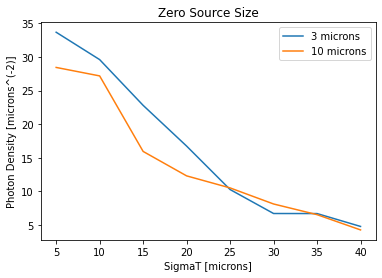

In [21]:
plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
plt.xlabel('SigmaT [microns]')
plt.ylabel(r'Photon Density [microns^(-2)]')
plt.legend()
plt.title('Zero Source Size')
plt.savefig(f'PhotonDensity_vs_sigmaT_Zero.png',dpi=200)

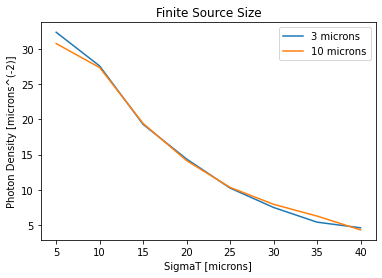

In [22]:
plt.plot(sigma,Pd[:,2],label=f'{spotsize1} microns')
plt.plot(sigma,Pd[:,3],label=f'{spotsize2} microns')
plt.xlabel('SigmaT [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title('Finite Source Size')
plt.legend()
plt.savefig(f'PhotonDensity_vs_sigmaT_Finite.png',dpi=200)